In [44]:
import pandas as pd
import numpy as np
import math
import keras
import tensorflow as tf
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [ ]:
# TO DO__
# pobawić się parametrami
# sposobem budwoania, liczba warst liczba neuronow itp
# pobawic sie wykresami i stworzyc jakies moze ladne te wykresy w koncu

In [45]:
data = pd.read_csv('Data/Scalanie2.csv', parse_dates=['Data'])

data.rename(columns = {'(pył zawieszony PM2.5 [jednostka ug/m3])':'PM2.5'
                    , '(pył zawieszony PM10 [jednostka ug/m3])':'PM10'
                    , '(tlenek azotu [jednostka ug/m3])':'NO'
                    , '(tlenki azotu [jednostka ug/m3])':'NOs'
                    , '(tlenek węgla [jednostka ug/m3])':'CO'
                    , '(benzen [jednostka ug/m3])':'benzen'
                    , '(dwutlenek azotu [jednostka ug/m3])':'NO2'
                    , 'Scalanie1.B00202A.Wynik':'Kierunek wiatru'
                    , 'Scalanie1.B00300S.Wynik':'Temperatura powietrza'
                    , 'Scalanie1.B00606S.Wynik':'Opady'
                    , 'Scalanie1.B00702A.Wynik':'Predkosc wiatru'
                    , 'Scalanie1.B00703A.Wynik':'MAX Predkosc wiatru'
                    , 'Scalanie1.B00802A.Wynik':'Wilgotnosc powietrza'
                    }, inplace = True)

data.dropna(inplace=True)
#data_df = data
# data_df = data_df.reset_index()
# data_df = data_df.drop('index', axis=1)
# data_df.index = data_df['Data']

data = data.drop(['Scalanie1.Stacja','Scalanie1.Data','Scalanie1.Rodzaj'], axis=1)
data['Data'] = pd.to_datetime(data['Data'])
data = data.sort_values(by="Data")

data.set_axis(data['Data'], inplace=True)
data.drop(columns=[ 'benzen', 'NO', 'NOs'], inplace=True)
data = data.drop('Data', axis=1)


In [46]:
data.shape

(22284, 10)

In [47]:
data

,PM2.5,PM10,CO,NO2,Kierunek wiatru,Temperatura powietrza,Opady,Predkosc wiatru,MAX Predkosc wiatru,Wilgotnosc powietrza
Data,,,,,,,,,,
2019-01-01 01:00:00,34.7,35.9,0.5,27.6,95.500000,0.566667,0.0,4.016667,4.666667,95.500000
2019-01-01 02:00:00,26.0,27.3,0.4,22.3,96.666667,0.050000,0.0,3.650000,4.333333,96.666667
2019-01-01 03:00:00,25.3,26.1,0.4,20.6,95.333333,-0.500000,0.0,2.850000,3.500000,95.333333
2019-01-01 04:00:00,28.2,28.8,0.4,19.2,94.833333,-0.566667,0.0,3.633333,4.333333,94.833333
2019-01-01 05:00:00,32.0,32.7,0.4,24.1,93.833333,-0.933333,0.0,3.716667,4.166667,93.833333
...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,18.6,22.6,0.6,26.0,86.833333,6.700000,0.0,4.216667,6.100000,86.833333
2021-12-31 20:00:00,16.6,20.4,0.5,24.5,86.000000,7.050000,0.0,4.183333,5.766667,86.000000
2021-12-31 21:00:00,18.5,22.5,0.5,23.7,87.500000,6.766667,0.0,4.350000,6.216667,87.500000


In [48]:
split_percent = 0.80
split = int(split_percent*len(data['PM2.5']))

df_train = data[:split]
df_test = data[split:]


In [49]:
df_train

,PM2.5,PM10,CO,NO2,Kierunek wiatru,Temperatura powietrza,Opady,Predkosc wiatru,MAX Predkosc wiatru,Wilgotnosc powietrza
Data,,,,,,,,,,
2019-01-01 01:00:00,34.7,35.9,0.5,27.6,95.500000,0.566667,0.0,4.016667,4.666667,95.500000
2019-01-01 02:00:00,26.0,27.3,0.4,22.3,96.666667,0.050000,0.0,3.650000,4.333333,96.666667
2019-01-01 03:00:00,25.3,26.1,0.4,20.6,95.333333,-0.500000,0.0,2.850000,3.500000,95.333333
2019-01-01 04:00:00,28.2,28.8,0.4,19.2,94.833333,-0.566667,0.0,3.633333,4.333333,94.833333
2019-01-01 05:00:00,32.0,32.7,0.4,24.1,93.833333,-0.933333,0.0,3.716667,4.166667,93.833333
...,...,...,...,...,...,...,...,...,...,...
2021-06-10 20:00:00,6.8,19.5,0.4,54.6,70.500000,15.466667,0.0,2.316667,2.966667,70.500000
2021-06-10 21:00:00,13.5,27.7,0.5,62.6,79.166667,14.016667,0.0,2.600000,3.300000,79.166667
2021-06-10 22:00:00,14.4,33.5,0.5,55.4,85.333333,13.000000,0.0,3.200000,3.800000,85.333333


In [50]:
list = [i for i in data.columns if i != 'Data']
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train[list])
scaled_test = scaler.transform(df_test[list])
# look_back = 3

# train_generator = TimeseriesGenerator(PM25_train, PM25_train, length=look_back, batch_size=20)
# test_generator = TimeseriesGenerator(PM25_test, PM25_test, length=look_back, batch_size=1)


In [51]:
def split_sequence(sequence, look_back, forecast_horizon):
 X = []
 y = []
 for i in range(len(sequence)): 
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)
 return np.array(X), np.array(y)

In [52]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY) 

In [53]:
n_features = len(data.columns)
n_features

10

In [54]:
LOOK_BACK = 24
n_features = len(data.columns)
trainX, trainY = createXY(scaled_train,LOOK_BACK)
testX, testY = createXY(scaled_test,LOOK_BACK)
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

trainX Shape--  (17803, 24, 10)
trainY Shape--  (17803,)
testX Shape--  (4433, 24, 10)
testY Shape--  (4433,)


In [55]:
trainX[0]

array([[0.12274496, 0.10976774, 0.09302326, 0.20444104, 0.94726562,
        0.35280679, 0.        , 0.23217726, 0.1921757 , 0.94726562],
       [0.09197029, 0.08240535, 0.06976744, 0.16385911, 0.9609375 ,
        0.3426893 , 0.        , 0.21098266, 0.17844887, 0.9609375 ],
       [0.08949416, 0.07858734, 0.06976744, 0.15084227, 0.9453125 ,
        0.33191906, 0.        , 0.16473988, 0.14413178, 0.9453125 ],
       [0.09975239, 0.08717786, 0.06976744, 0.14012251, 0.93945312,
        0.33061358, 0.        , 0.21001927, 0.17844887, 0.93945312],
       [0.1131942 , 0.09958638, 0.06976744, 0.17764165, 0.92773437,
        0.32343342, 0.        , 0.21483622, 0.17158545, 0.92773437],
       [0.1054121 , 0.09195037, 0.06976744, 0.15007657, 0.91210938,
        0.32310705, 0.        , 0.21098266, 0.20590254, 0.91210938],
       [0.09727626, 0.08431435, 0.06976744, 0.13169985, 0.83203125,
        0.34432115, 0.        , 0.28998073, 0.28140014, 0.83203125],
       [0.09090909, 0.07858734, 0.0697674

In [56]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [60]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(LOOK_BACK,10)))
    grid_model.add(LSTM(50))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

In [61]:
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

C:\Users\cezary.cwikla\AppData\Local\Temp\ipykernel_8892\3840368478.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [62]:
grid_search = grid_search.fit(trainX,trainY)


Epoch 1/8
557/557 [==============================] - 9s 12ms/step - loss: 0.0016 - val_loss: 8.9325e-04
Epoch 2/8
557/557 [==============================] - 7s 12ms/step - loss: 7.9600e-04 - val_loss: 5.6644e-04
Epoch 3/8
557/557 [==============================] - 7s 12ms/step - loss: 6.3490e-04 - val_loss: 4.5590e-04
Epoch 4/8
557/557 [==============================] - 7s 13ms/step - loss: 5.8867e-04 - val_loss: 5.1629e-04
Epoch 5/8
557/557 [==============================] - 8s 15ms/step - loss: 5.5379e-04 - val_loss: 4.9347e-04
Epoch 6/8
557/557 [==============================] - 9s 16ms/step - loss: 5.1118e-04 - val_loss: 6.8051e-04
Epoch 7/8
557/557 [==============================] - 9s 16ms/step - loss: 5.0032e-04 - val_loss: 4.3510e-04
Epoch 8/8
557/557 [==============================] - 2s 4ms/step - loss: 9.5379e-04
Epoch 1/8
557/557 [==============================] - 11s 16ms/step - loss: 0.0016 - val_loss: 8.9115e-04
Epoch 2/8
557/557 [==============================] - 9s 16m

Epoch 2/8
446/446 [==============================] - 8s 17ms/step - loss: 7.8967e-04 - val_loss: 5.7370e-04
Epoch 3/8
446/446 [==============================] - 8s 17ms/step - loss: 6.5815e-04 - val_loss: 5.6067e-04
Epoch 4/8
446/446 [==============================] - 7s 16ms/step - loss: 5.7907e-04 - val_loss: 4.6172e-04
Epoch 5/8
446/446 [==============================] - 8s 17ms/step - loss: 5.5231e-04 - val_loss: 4.6633e-04
Epoch 6/8
446/446 [==============================] - 7s 16ms/step - loss: 5.6112e-04 - val_loss: 4.2022e-04
Epoch 7/8
446/446 [==============================] - 7s 17ms/step - loss: 5.1259e-04 - val_loss: 4.1496e-04
Epoch 8/8
446/446 [==============================] - 2s 5ms/step - loss: 3.6868e-04
Epoch 1/8
446/446 [==============================] - 10s 18ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2/8
446/446 [==============================] - 7s 17ms/step - loss: 7.7313e-04 - val_loss: 6.7813e-04
Epoch 3/8
446/446 [==============================] - 7s 17m

891/891 [==============================] - 15s 17ms/step - loss: 5.1100e-04 - val_loss: 4.3070e-04
Epoch 4/8
891/891 [==============================] - 16s 18ms/step - loss: 4.7414e-04 - val_loss: 4.1200e-04
Epoch 5/8
891/891 [==============================] - 15s 16ms/step - loss: 4.6497e-04 - val_loss: 4.8743e-04
Epoch 6/8
891/891 [==============================] - 16s 18ms/step - loss: 4.4887e-04 - val_loss: 3.8896e-04
Epoch 7/8
891/891 [==============================] - 15s 17ms/step - loss: 4.3491e-04 - val_loss: 4.7930e-04
Epoch 8/8
891/891 [==============================] - 14s 16ms/step - loss: 4.2600e-04 - val_loss: 3.8378e-04


In [63]:
grid_search.best_params_


{'batch_size': 20, 'epochs': 8, 'optimizer': 'adam'}

In [64]:
my_model=grid_search.best_estimator_.model


In [68]:
prediction=my_model.predict(testX)
prediction_copies_array = np.repeat(prediction,10, axis=-1)


In [69]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.07325844]
 [0.06047279]
 [0.07417859]
 ...
 [0.05500811]
 [0.0622183 ]
 [0.05754748]]

Prediction Shape- (4433, 1)


In [70]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),10)))[:,0]


In [74]:
original_copies_array = np.repeat(testY,10, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),10)))[:,0]

In [75]:
from matplotlib import pyplot as plt


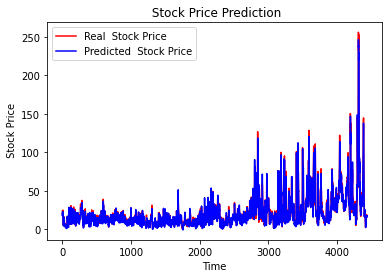

In [76]:
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [ ]:
#old -- do wywalenia raczej
# model = Sequential()
# model.add(LSTM(15,  activation='relu', input_shape=(LOOK_BACK, 10)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# num_epochs = 25
# model.fit(epochs=num_epochs, verbose=1)


In [ ]:
# prediction = model.predict(test_generator)

# PM25_train = PM25_train.reshape((-1))
# PM25_test = PM25_test.reshape((-1))
# prediction = prediction.reshape((-1))


In [78]:
prediction.shape

(4433, 1)

In [79]:
testY.shape

(4433,)

In [88]:
testScore = math.sqrt(mean_squared_error(original, pred))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 5.54 RMSE


In [83]:
trainY

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

In [86]:
trace1 = go.Scatter(
    y = trainY,
    mode = 'lines',
    name = 'Dane'
)
trace2 = go.Scatter(
    y = pred,
    mode = 'lines',
    name = 'Predykcja'
)
trace3 = go.Scatter(
    y = original,
    mode='lines',
    name = 'Rzeczywistość'
)
layout = go.Layout(
    title = "Predykcja PM2.5",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "PM2.5[ug/m3]"}
)
fig = go.Figure(data=[ trace2, trace3], layout=layout)
fig.show()

In [ ]:
# close_data = close_data.reshape((-1))


# def predict(num_prediction, model):
#     prediction_list = close_data[-look_back:]

#     for _ in range(num_prediction):
#         x = prediction_list[-look_back:]
#         x = x.reshape((1, look_back, 1))
#         out = model.predict(x)[0][0]
#         prediction_list = np.append(prediction_list, out)
#     prediction_list = prediction_list[look_back - 1:]

#     return prediction_list


# def predict_dates(num_prediction):
#     last_date = df['Date'].values[-1]
#     prediction_dates = pd.date_range(last_date, periods=num_prediction + 1).tolist()
#     return prediction_dates


# num_prediction = 30
# forecast = predict(num_prediction, model)
# forecast_dates = predict_dates(num_prediction)

In [ ]:
print(data)